In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader, Subset, random_split
import os
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
# Define transformations for the training and testing datasets
im_H = 224
im_W = 224

#H and W set to 224 for resNet50

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((im_H, im_W)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(30),
        transforms.RandomResizedCrop((im_H, im_W), scale=(0.8, 1.0)),
        transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.4),
        transforms.RandomGrayscale(p=0.1),
        transforms.ElasticTransform(alpha=1.0, sigma=0.2),
        transforms.RandomCrop(224),
        transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.4),

        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize((im_H, im_W)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}


In [ ]:
# Set the directory 
data_dir = 'drive/MyDrive/Melanoma/dataset'
batch_size = 32

image_datasets = {
    'train': datasets.ImageFolder(os.path.join(data_dir, 'tr_10k'),
                                 data_transforms['train']),
    'test': datasets.ImageFolder(os.path.join(data_dir, 'test'),
                                data_transforms['test'])
}
train_dataset = image_datasets['train']
test_dataset = image_datasets['test']

train_size = int(0.8 * len(train_dataset))  # 80% for training
val_size = len(train_dataset) - train_size  # Remaining 20% for validation

# Split the dataset
train_subset, val_subset = random_split(train_dataset, [train_size, val_size])


dataloaders = {
    'train':torch.utils.data.DataLoader(train_subset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2
                                       ),
    'val':torch.utils.data.DataLoader(val_subset,
                                        batch_size=batch_size,
                                        shuffle=True,
                                        num_workers=2
                                       ),
    'test':torch.utils.data.DataLoader(image_datasets['test'],
                                        batch_size=batch_size,
                                        shuffle=False,
                                        num_workers=2)
}

#for Visualization
dataset_sizes = {
    'train':len(train_dataset),
    'test':len(image_datasets['test'])
}

print(f"Number of data: {dataset_sizes}")

class_names = train_dataset.classes
print(f"Classes: {class_names}")


Number of data: {'train': 9605, 'test': 1000}
Classes: ['benign', 'malignant']


##Visualise transformations

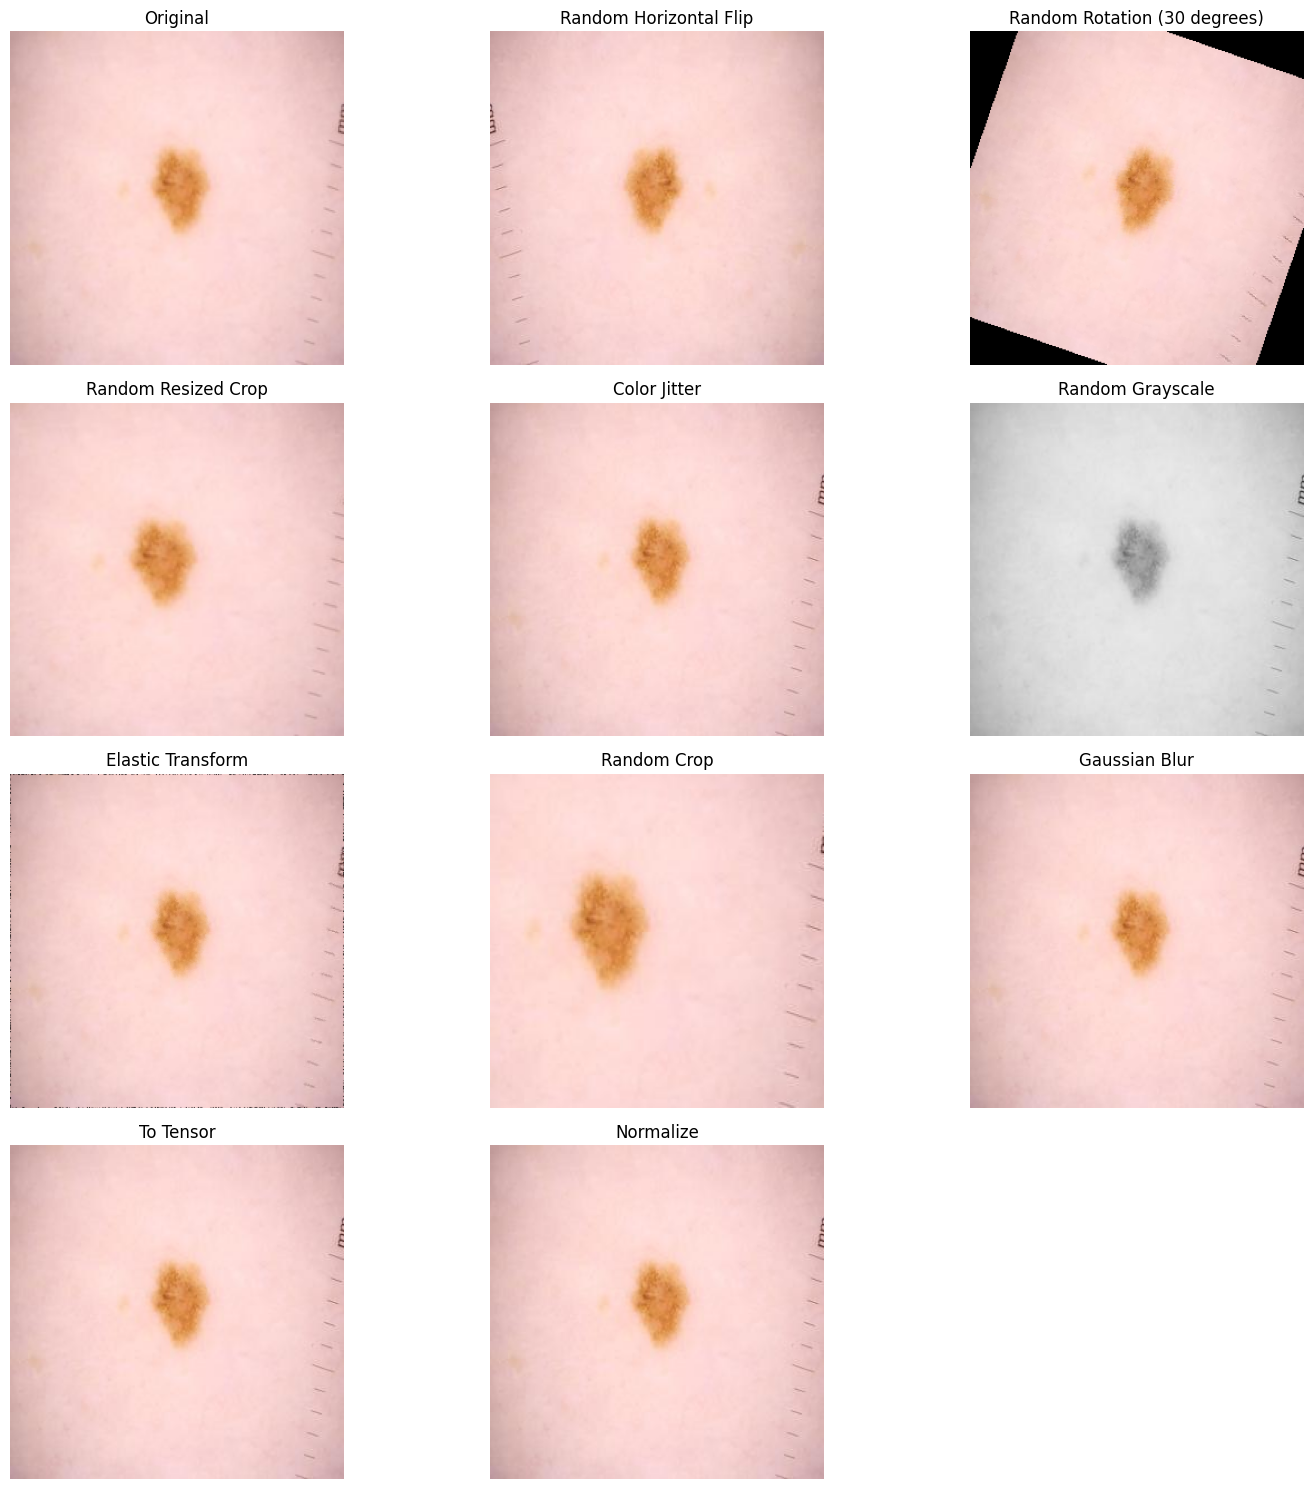

In [ ]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import os

# Function to un-normalize and convert tensors back to images
def unnormalize_image(tensor, mean, std):
    tensor = tensor.clone()  # Clone to avoid modifying the original tensor
    for t, m, s in zip(tensor, mean, std):
        t.mul_(s).add_(m)  # Reverse the normalization process
    return tensor

# Function to convert a tensor to a numpy array for plotting
def tensor_to_image(tensor):
    tensor = tensor.permute(1, 2, 0)  # Change dimensions from (C, H, W) to (H, W, C)
    tensor = tensor.numpy()
    return np.clip(tensor, 0, 1)  # Clip to avoid values outside [0, 1] range

# Load a sample image
sample_image_path = 'drive/MyDrive/Melanoma/dataset/tr_10k/benign/melanoma_0.jpg'  # path to a sample image
image = Image.open(sample_image_path)

# Define individual transformations
transformations = {
    'Original': transforms.Resize((im_H, im_W)),
    'Random Horizontal Flip': transforms.RandomHorizontalFlip(p=1.0),
    'Random Rotation (30 degrees)': transforms.RandomRotation(30),
    'Random Resized Crop': transforms.RandomResizedCrop((im_H, im_W), scale=(0.8, 1.0)),
    'Color Jitter': transforms.RandomApply([transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1)], p=0.4),
    'Random Grayscale': transforms.RandomGrayscale(p=1.0),
    'Elastic Transform': transforms.ElasticTransform(alpha=1.0, sigma=0.2),
    'Random Crop': transforms.RandomCrop(224),
    'Gaussian Blur': transforms.RandomApply([transforms.GaussianBlur(kernel_size=3)], p=0.4),
    'To Tensor': transforms.ToTensor(),
    'Normalize': transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
}

# Apply each transformation and plot the results
plt.figure(figsize=(15, 15))
columns = 3
rows = (len(transformations) + 2) // columns  # Calculate required rows

# Initialize the image as a PIL image first
for i, (name, transform) in enumerate(transformations.items()):
    plt.subplot(rows, columns, i+1)

    if name == 'To Tensor':
        transformed_image = transform(image)  # Apply To Tensor
        transformed_image_np = tensor_to_image(transformed_image)  # Convert to numpy for plotting
    elif name == 'Normalize':
        # convert to tensor and then normalize
        transformed_image = transforms.Compose([transforms.ToTensor(), transform])(image)
        transformed_image = unnormalize_image(transformed_image, [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Un-normalize
        transformed_image_np = tensor_to_image(transformed_image)  # Convert to numpy for plotting
    else:
        transformed_image = transform(image)  # For PIL-based transforms
        if isinstance(transformed_image, torch.Tensor):
            transformed_image_np = tensor_to_image(transformed_image)  # Convert to numpy if tensor
        else:
            transformed_image_np = np.array(transformed_image)  # If it's a PIL image, convert to numpy directly

    plt.imshow(transformed_image_np)
    plt.title(name)
    plt.axis('off')

plt.tight_layout()
plt.show()


##Segmentation##


In [ ]:
from torch.nn import functional as F

def double_conv(in_channels, out_channels):
    conv = nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
        nn.ReLU(inplace=True))

    return conv

def crop_tensor(tensor, target_tensor):
    target_size = target_tensor.size()[2]
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size
    delta = delta // 2
    return tensor[
        :,
        :,
        delta:tensor_size-delta,
        delta: tensor_size-delta
    ]

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super(UNet, self).__init__()

        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.down_conv_1 = double_conv(3,64)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128,256)
        self.down_conv_4 = double_conv(256,512)
        self.down_conv_5 = double_conv(512,1024)

        self.up_trans_1 = nn.ConvTranspose2d(
            in_channels=1024,
            out_channels=512,
            kernel_size=2,
            stride=2
        )

        self.up_conv_1 = double_conv(1024, 512)

        self.up_trans_2 = nn.ConvTranspose2d(
            in_channels=512,
            out_channels=256,
            kernel_size=2,
            stride=2
        )

        self.up_conv_2 = double_conv(512, 256)

        self.up_trans_3 = nn.ConvTranspose2d(
            in_channels=256,
            out_channels=128,
            kernel_size=2,
            stride=2
        )

        self.up_conv_3 = double_conv(256, 128)

        self.up_trans_4 = nn.ConvTranspose2d(
            in_channels=128,
            out_channels=64,
            kernel_size=2,
            stride=2
        )

        self.up_conv_4 = double_conv(128, 64)

        self.out = nn.Conv2d(
            in_channels=64,
            out_channels=out_channels,
            kernel_size=1
        )


    def forward(self, image):
        #encoder
        x1 = self.down_conv_1(image)
        x2 = self.max_pool_2x2(x1)
        x3 = self.down_conv_2(x2)
        x4 = self.max_pool_2x2(x3)
        x5 = self.down_conv_3(x4)
        x6 = self.max_pool_2x2(x5)
        x7 = self.down_conv_4(x6)
        x8 = self.max_pool_2x2(x7)
        x9 = self.down_conv_5(x8)

        #decoder
        x = self.up_trans_1(x9)
        y = crop_tensor(x7, x)
        x = self.up_conv_1(torch.cat([x,y], axis=1))

        x = self.up_trans_2(x)
        y = crop_tensor(x5, x)
        x = self.up_conv_2(torch.cat([x,y], axis=1))

        x = self.up_trans_3(x)
        y = crop_tensor(x3, x)
        x = self.up_conv_3(torch.cat([x,y], axis=1))

        x = self.up_trans_4(x)
        y = crop_tensor(x1, x)
        x = self.up_conv_4(torch.cat([x,y], axis=1))

        #output
        out = self.out(x)

        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
segmentation_model = UNet(in_channels=3, out_channels=1)
state_dict = torch.load('drive/MyDrive/Melanoma/models/segmentation_v5_state_dict.pth',
                          map_location=device)
segmentation_model.load_state_dict(state_dict)
segmentation_model.to(device)
segmentation_model.eval()

<ipython-input-6-ded8a10e1154>:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  state_dict = torch.load('drive/MyDrive/Melanoma/models/segmentation_v5_state_dict.pth',


UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3)

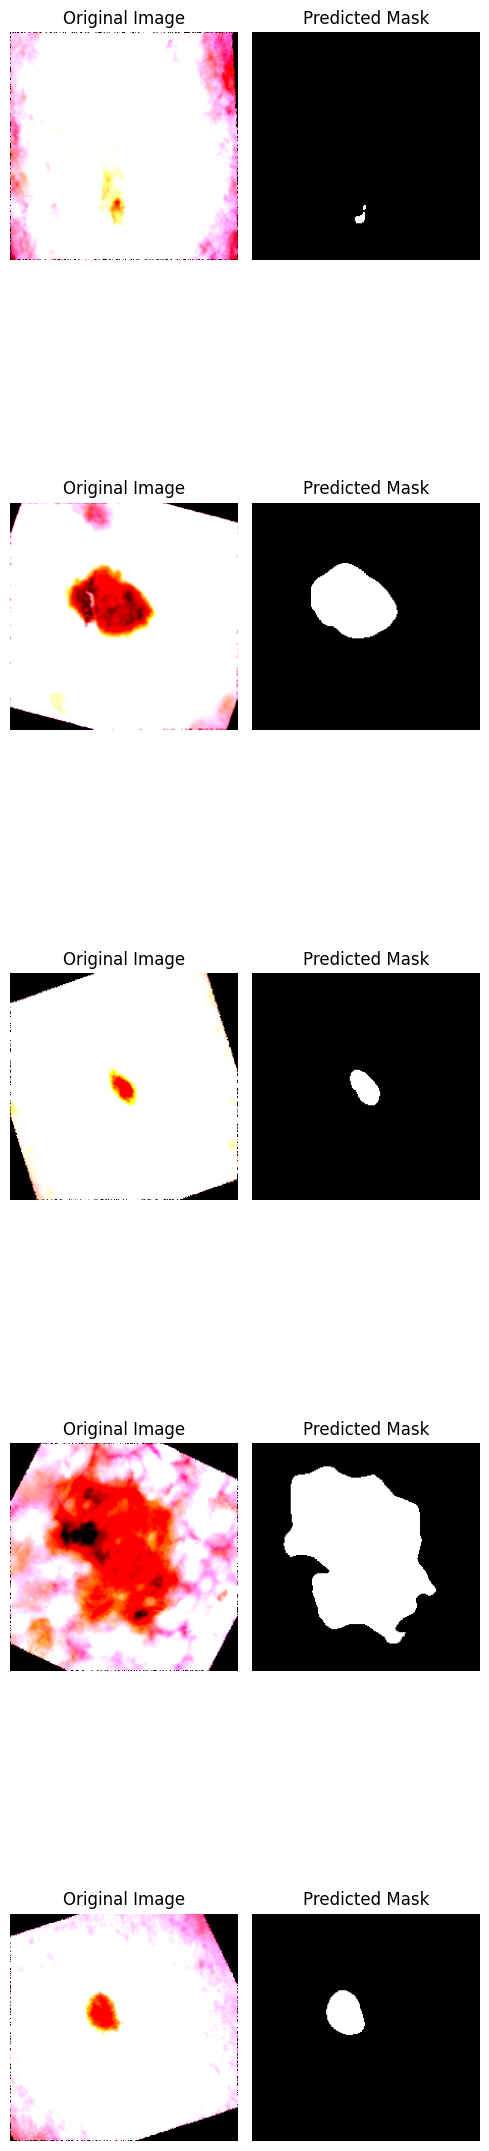

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision import transforms

def visualize_segmentation_results(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode

    # Get a batch of images and masks from the dataloader
    images, _ = next(iter(dataloader))  # Assuming masks are not needed here
    images = images.to(device)

    # Generate predictions
    with torch.no_grad():
        outputs = model(images)

    # Post-process the outputs to get binary masks
    preds = torch.sigmoid(outputs).cpu()
    preds = (preds > 0.5).float()  # Thresholding to get binary masks

    # Move data to CPU and convert to numpy arrays for visualization
    images = images.cpu().numpy()
    preds = preds.cpu().numpy()

    # Plot images and predicted masks
    num_images = min(5, len(images))  # Display up to 4 images
    fig, axes = plt.subplots(num_images, 2, figsize=(5, num_images * 5))

    for i in range(num_images):
        # Original image
        axes[i, 0].imshow(np.transpose(images[i], (1, 2, 0)))
        axes[i, 0].set_title('Original Image')
        axes[i, 0].axis('off')

        # Predicted mask
        axes[i, 1].imshow(preds[i][0], cmap='gray')  # Display mask as grayscale
        axes[i, 1].set_title('Predicted Mask')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

visualize_segmentation_results(segmentation_model, dataloaders['train'], device)

In [ ]:
#####################RESNET50######################
model = models.resnet50(pretrained=True)
# model = models.resnet101(pretrained=True)
# model = models.resnet152(pretrained=True)
num_classes=2

#freeze layers in base model
for param in model.parameters():
  param.requires_grad = False

#Updating ResNet's final layer
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 2048),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(2048, 1024),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(1024, 512),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes)
)
#
#to finetune entire model
for param in model.parameters():
  param.requires_grad = True

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)



/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 60.0MB/s]


In [ ]:
import torch.optim.lr_scheduler as lr_scheduler
from sklearn.utils.class_weight import compute_class_weight

import numpy as np

# Get the labels from the entire training dataset before splitting
all_labels = [label for _, label in image_datasets['train'].samples]

# Calculate class weights using sklearn's compute_class_weight
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(all_labels), y=all_labels)

# Convert the class weights to a tensor and move to the appropriate device
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Print the computed class weights for verification
print(f"Class Weights: {class_weights}")

########
# criterion = nn.CrossEntropyLoss(weight=class_weights)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = lr_scheduler.StepLR(optimizer,
                                step_size=10,
                                gamma=0.2)




Class Weights: tensor([0.9605, 1.0429], device='cuda:0')


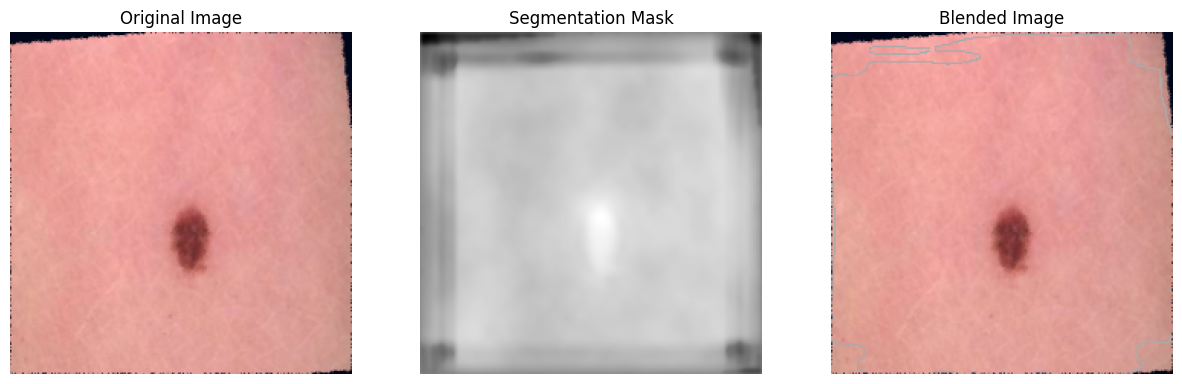

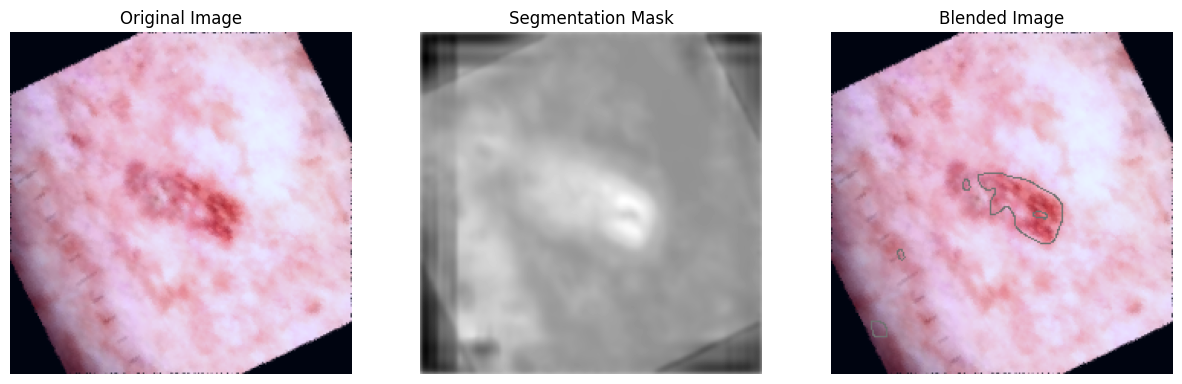

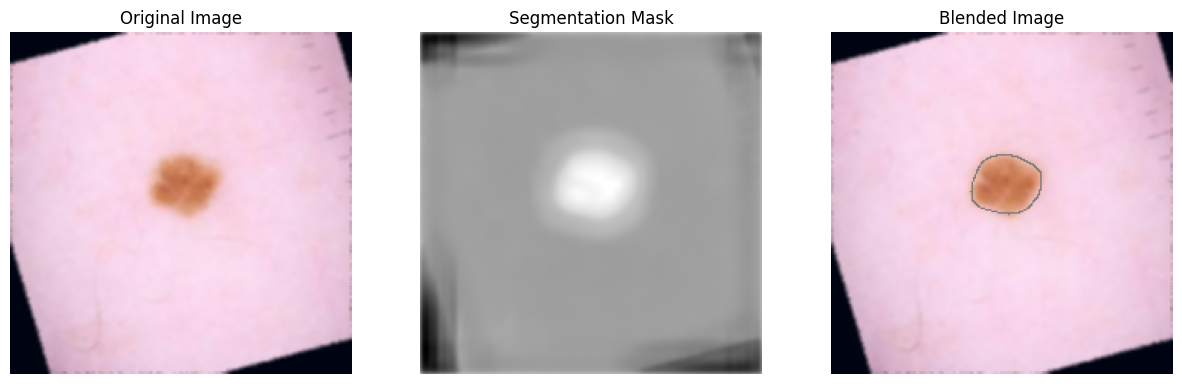

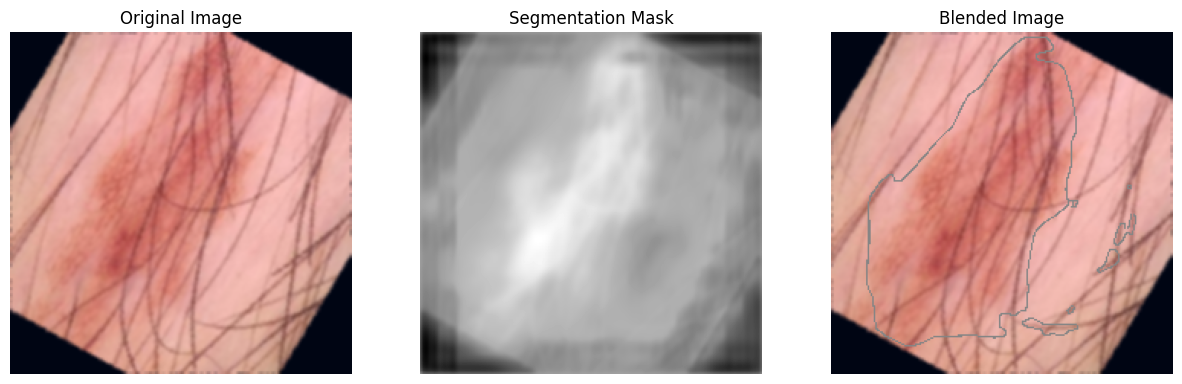

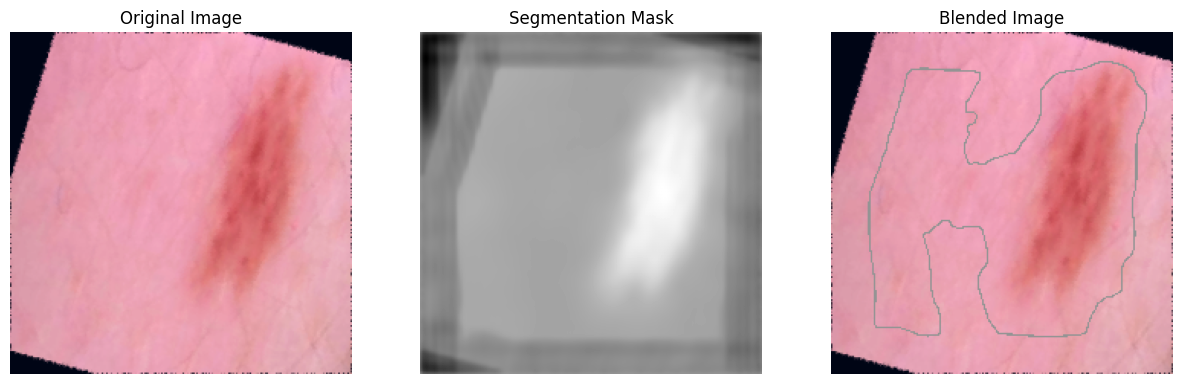

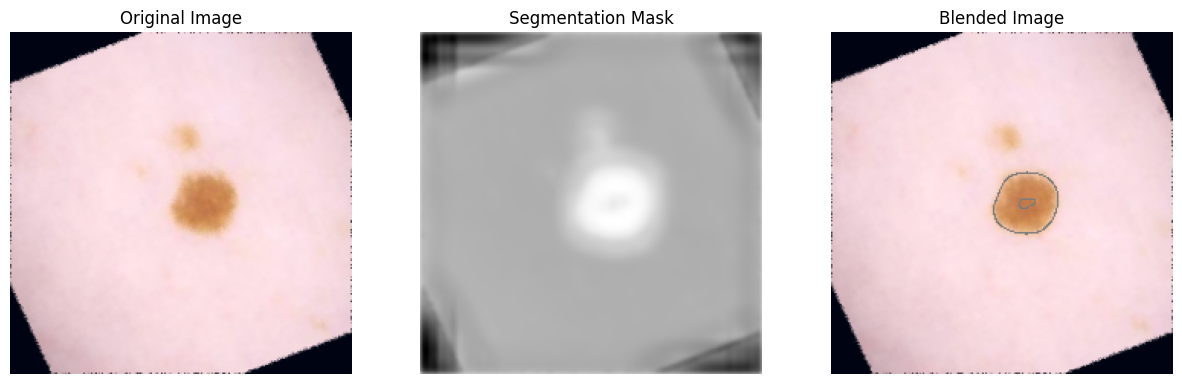

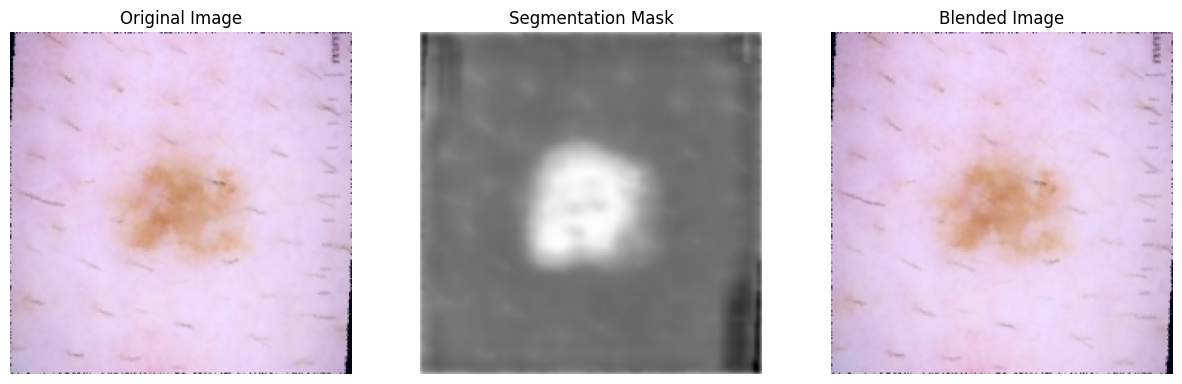

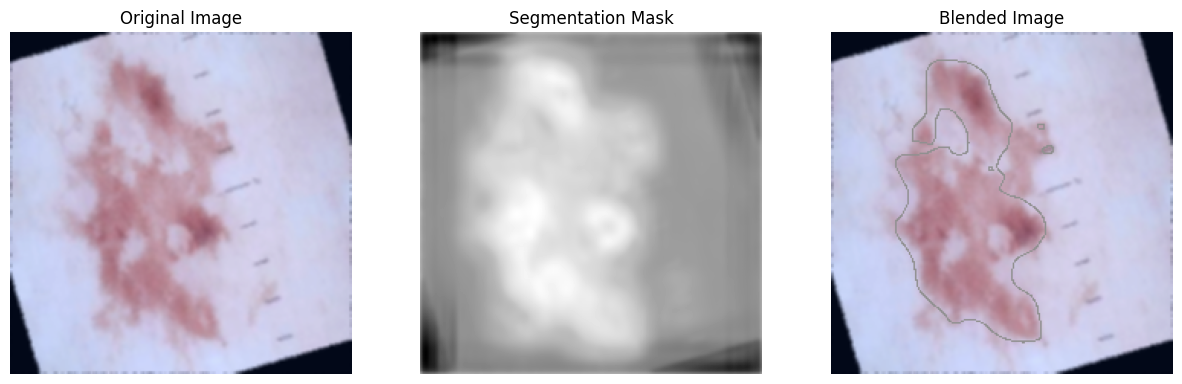

In [ ]:
import torch
seg_alpha = 0.8
seg_highlight_factor = 4.0

import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from skimage import feature

outline_color = (0, 0, 0)

def add_outline_to_image(original_images, segmented_images, outline_color=outline_color, alpha=1.0, edge_thickness=3):
    """
    Adds an outline to the original image based on the white region in the segmentation mask.
    The outline is obtained from the edges of the white region (lesion) in the mask.
    """
    # Ensure batch size matches
    if original_images.shape[0] != segmented_images.shape[0]:
        raise ValueError("Batch sizes of original_images and segmented_images do not match.")

    # Resize the segmented images to match the original image size
    segmented_images_resized = F.interpolate(segmented_images,
                                             size=(original_images.shape[2], original_images.shape[3]),
                                             mode='bilinear',
                                             align_corners=False)

    # Convert to single-channel (grayscale) if not already
    if segmented_images_resized.shape[1] == 3:
        segmented_images_resized = segmented_images_resized.mean(dim=1, keepdim=True)

    # Apply a threshold to focus on the white regions (lesion area) of the mask
    thresholded_mask = (segmented_images_resized > 0.5).float()

    # Apply Canny edge detection to the thresholded mask
    edges = []
    for i in range(thresholded_mask.shape[0]):
        mask_np = thresholded_mask[i].cpu().squeeze().numpy()
        # Use skimage Canny edge detection
        edge_map = feature.canny(mask_np, sigma=1.0)
        edges.append(edge_map)

    # Stack the edges into a tensor and send it to the same device as the original images
    edges_tensor = torch.tensor(np.array(edges)).unsqueeze(1).float().to(original_images.device)

    # Create an outline mask where edges are detected
    outline_mask = (edges_tensor > 0).float()

    # Overlay the outline on the original image
    outline_color_tensor = torch.tensor(outline_color).float().to(original_images.device) / 255.0
    outline_image = original_images.clone()

    # For each channel, overlay the outline with the chosen color
    for c in range(3):
        outline_image[:, c, :, :] = torch.where(outline_mask.squeeze(1) > 0,
                                                outline_color_tensor[c] * alpha,
                                                original_images[:, c, :, :])

    return outline_image



# Function to visualize images side by side
def visualize_side_by_side(original_image, segmented_image, blended_image):
    """
    Visualize the original image, segmented image, and blended image side by side.
    """
    # Convert tensors to numpy arrays for visualization
    original_np = original_image.squeeze().cpu().numpy().transpose(1, 2, 0)
    blended_np = blended_image.squeeze().cpu().numpy().transpose(1, 2, 0)

    # Normalize images for visualization
    original_np = (original_np - original_np.min()) / (original_np.max() - original_np.min())
    blended_np = (blended_np - blended_np.min()) / (blended_np.max() - blended_np.min())

    # For segmentation mask, normalize it and no need to transpose (single channel)
    segmented_np = segmented_image.squeeze().cpu().numpy()
    # seg = torch.sigmoid(segmented_image).cpu()
    # seg = (seg > 0.5).float()
    # segmented_np = segmented_image.cpu().numpy()

    # Create a figure with 3 subplots
    fig, ax = plt.subplots(1, 3, figsize=(15, 5))

    # Original image
    ax[0].imshow(original_np)
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    # Segmented image (showing the single channel as grayscale)
    ax[1].imshow(segmented_np, cmap='gray')
    ax[1].set_title('Segmentation Mask')
    ax[1].axis('off')

    # Blended image
    ax[2].imshow(blended_np)
    ax[2].set_title('Blended Image')
    ax[2].axis('off')

    plt.show()

# Function to visualize outlined data
def visualize_outlined_data(testLoader, img_arr_num, outline_color=outline_color):
    for inputs, labels in testLoader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Generate segmented images using the segmentation model
        with torch.no_grad():
            segmented_images = segmentation_model(inputs)

        # Add outline to the images
        outlined_images = add_outline_to_image(inputs, segmented_images, outline_color)

        # Visualize original image, segmented image, and outlined image side by side
        visualize_side_by_side(inputs[img_arr_num], segmented_images[img_arr_num], outlined_images[img_arr_num])

        break  # Process a single batch


for i in range(0,8):
  # visualise_blended_data(dataloaders['train'], i)
    visualize_outlined_data(dataloaders['train'], i, outline_color=(0, 0, 0))

In [ ]:
num_epochs = 30
trainLoader = dataloaders['train']
valLoader = dataloaders['val']
testLoader = dataloaders['test']

# Lists to store accuracy and loss
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

In [ ]:
# Initialize early stopping parameters
patience = 5  # Number of epochs to wait for improvement before stopping
best_val_loss = float('inf')  # Start with a very high value for the best loss
epochs_no_improve = 0  # Counter for epochs without improvement

torch.cuda.empty_cache()

for epoch in range(num_epochs):
    model.train()

    running_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in trainLoader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Concatenate imageswith torch.no_grad():
        segmented_image = segmentation_model(inputs)
        # concatenate_inputs = concatenate_images(inputs, segmentation_model)
        blend_inputs = add_outline_to_image(inputs,
                                            segmented_image)
                                            # alpha=seg_alpha)
                                            # highlight_factor=seg_highlight_factor)

        optimizer.zero_grad()

        outputs = model(blend_inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        correct_train += (predicted == labels).sum().item()
        total_train += labels.size(0)

    train_loss = running_loss / len(trainLoader.dataset)
    train_losses.append(train_loss)

    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    running_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in valLoader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Concatenate images
            # concatenate_inputs = blend_with_highlighted_segment(inputs,
                                                                # segmentation_model,
                                                                # alpha=0.7,
                                                                # highlight_factor=2.0)
            # Concatenate imageswith torch.no_grad():
            segmented_image = segmentation_model(inputs)
          # concatenate_inputs = concatenate_images(inputs, segmentation_model)
            blend_inputs = add_outline_to_image(inputs,
                                                segmented_image)
                                                # alpha=seg_alpha)
                                                # highlight_factor=seg_highlight_factor)

            outputs = model(blend_inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            correct_val += (predicted == labels).sum().item()
            total_val += labels.size(0)

    # Calculate validation loss and accuracy
    val_loss = running_loss / len(valLoader.dataset)
    val_losses.append(val_loss)

    val_accuracy = 100 * correct_val / total_val
    val_accuracies.append(val_accuracy)

    print(f'Epoch {epoch + 1}/{num_epochs}, '
          f'Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%,\n'
          f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')

    scheduler.step()

    # Early stopping check
    # if val_loss < best_val_loss:
    #     best_val_loss = val_loss  # Update best validation loss
    #     epochs_no_improve = 0  # Reset counter if there's an improvement
    # else:
    #     epochs_no_improve += 1  # Increment counter if no improvement

    # # Check if early stopping should be applied
    # if epochs_no_improve >= patience:
    #     print(f'Early stopping triggered at epoch {epoch + 1}')
    #     break


Epoch 1/30, Train Loss: 0.3388, Train Accuracy: 84.75%,
Val Loss: 0.2764, Val Accuracy: 88.60%
Epoch 2/30, Train Loss: 0.2454, Train Accuracy: 90.41%,
Val Loss: 0.2200, Val Accuracy: 90.94%
Epoch 3/30, Train Loss: 0.2272, Train Accuracy: 91.15%,
Val Loss: 0.2043, Val Accuracy: 92.45%
Epoch 4/30, Train Loss: 0.2140, Train Accuracy: 91.76%,
Val Loss: 0.2478, Val Accuracy: 90.27%
Epoch 5/30, Train Loss: 0.2115, Train Accuracy: 91.53%,
Val Loss: 0.2436, Val Accuracy: 90.06%
Epoch 6/30, Train Loss: 0.1978, Train Accuracy: 92.17%,
Val Loss: 0.2183, Val Accuracy: 90.58%
Epoch 7/30, Train Loss: 0.1904, Train Accuracy: 92.56%,
Val Loss: 0.2050, Val Accuracy: 91.72%
Epoch 8/30, Train Loss: 0.1826, Train Accuracy: 92.86%,
Val Loss: 0.1955, Val Accuracy: 92.14%
Epoch 9/30, Train Loss: 0.1802, Train Accuracy: 93.09%,
Val Loss: 0.2089, Val Accuracy: 92.35%
Epoch 10/30, Train Loss: 0.1783, Train Accuracy: 93.08%,
Val Loss: 0.1903, Val Accuracy: 92.56%
Epoch 11/30, Train Loss: 0.1467, Train Accuracy: 

In [ ]:
model_path = 'drive/MyDrive/Melanoma/models/model_outline_v8.pth'

# Save the entire model
torch.save(model, model_path)

In [ ]:
# model = torch.load("drive/MyDrive/Melanoma/models/model_blend_v15.pth")
model = torch.load("drive/MyDrive/Melanoma/models/model_outline_v8.pth")

<ipython-input-16-98777e365119>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load("drive/MyDrive/Melanoma/models/model_outline_v8.pth")


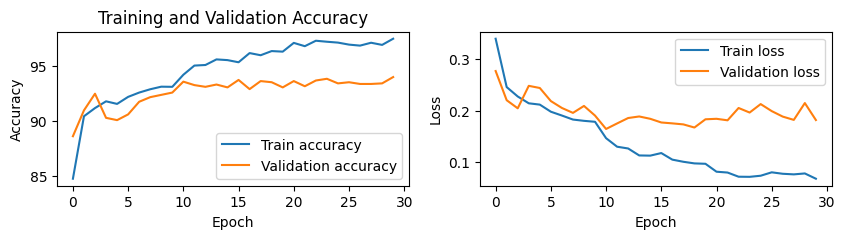

In [ ]:
plt.figure(figsize=(10, 2))

plt.subplot(1, 2, 1)
plt.plot(train_accuracies, label='Train accuracy')
plt.plot(val_accuracies, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

Accuracy: 0.9280
Precision: 0.9864
Recall: 0.8680
F1 Score: 0.9234
ROC AUC Score: 0.9798


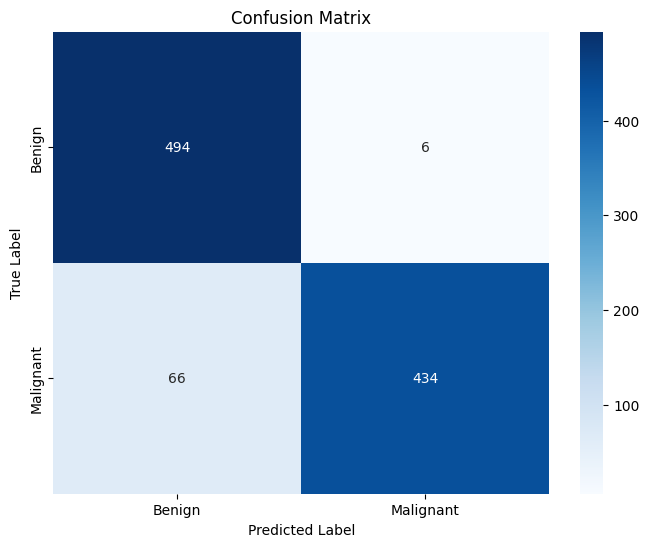

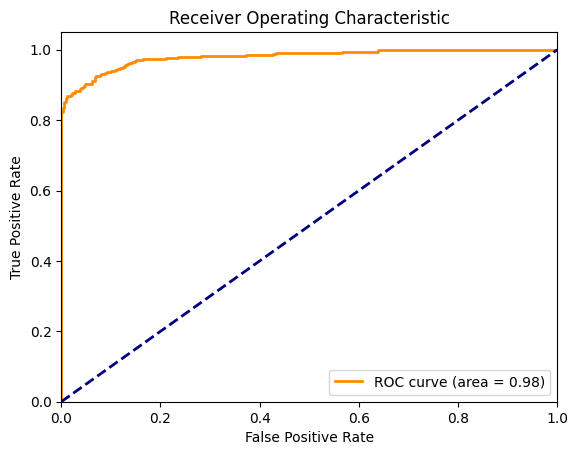

In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Set the model to evaluation mode
model.eval()

all_labels = []
all_preds = []
all_probs = []

# Load data
testLoader = dataloaders['test']

# Disable gradient calculations
with torch.no_grad():
    for inputs, labels in testLoader:
        # Move data to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Concatenate imageswith torch.no_grad():
        segmented_image = segmentation_model(inputs)
        # concatenate_inputs = concatenate_images(inputs, segmentation_model)
        blend_inputs = add_outline_to_image(inputs,
                                            segmented_image)

        # Forward pass
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs, 1)

        # Store labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  

# Calculate Metrics
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='binary')
recall = recall_score(all_labels, all_preds, average='binary')
f1 = f1_score(all_labels, all_preds, average='binary')
roc_auc = roc_auc_score(all_labels, all_probs)

# Print Metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc:.4f}')

# Confusion Matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plot ROC AUC Curve
fpr, tpr, _ = roc_curve(all_labels, all_probs)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Total misclassified melanoma images: 72
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10105.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10107.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10108.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10112.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10114.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10115.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10116.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10118.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10119.jpg
Misclassified image path: drive/MyDrive/Melanoma/dataset/test/malignant/melanoma_10120.jpg
Misclassified image path: drive/MyDrive/Melanoma/d

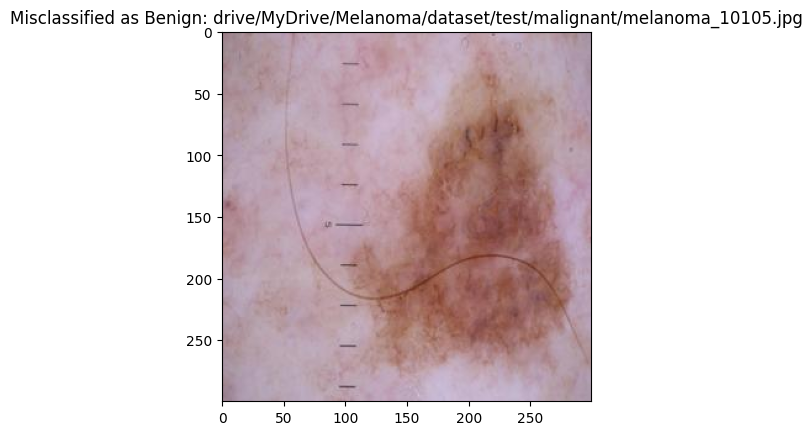

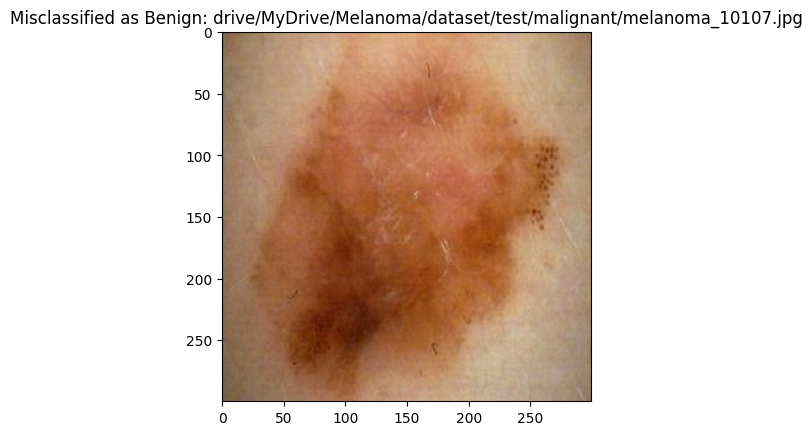

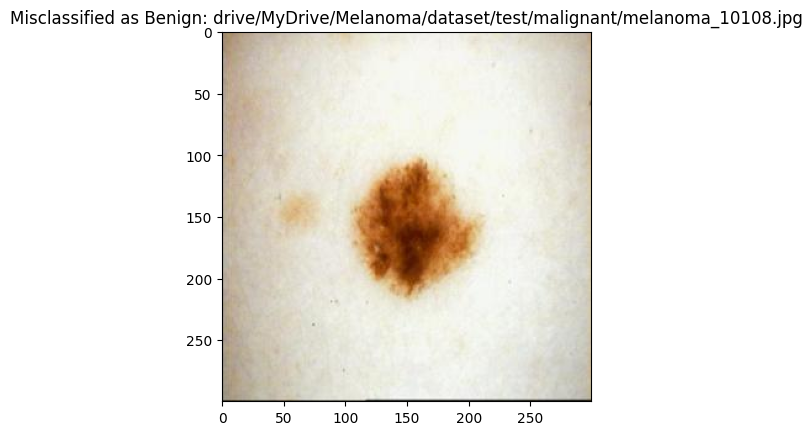

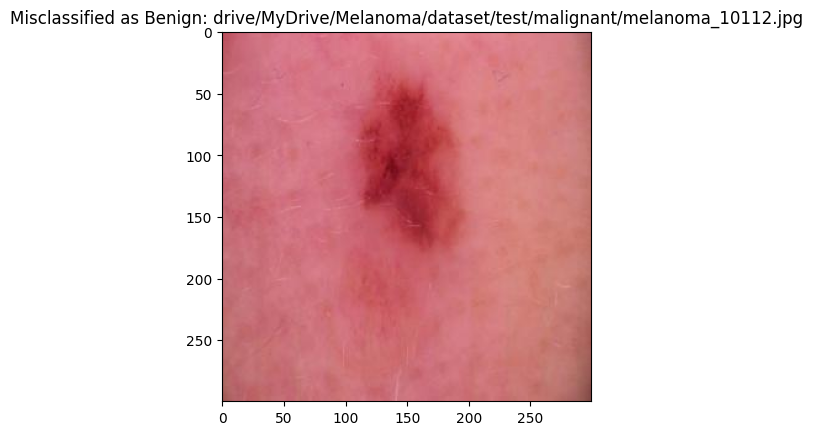

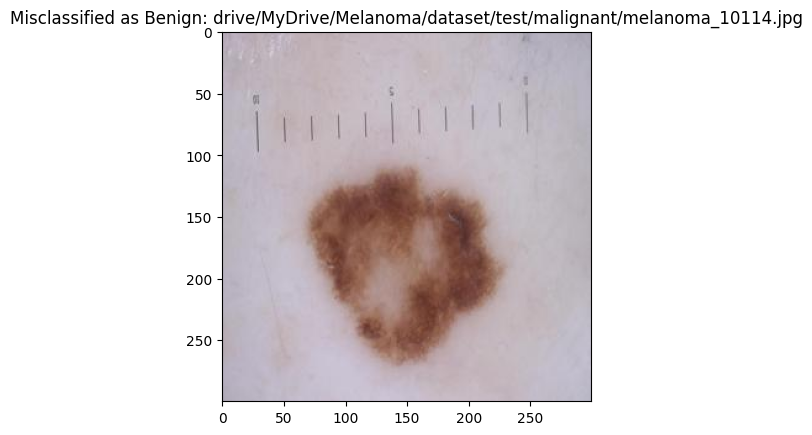

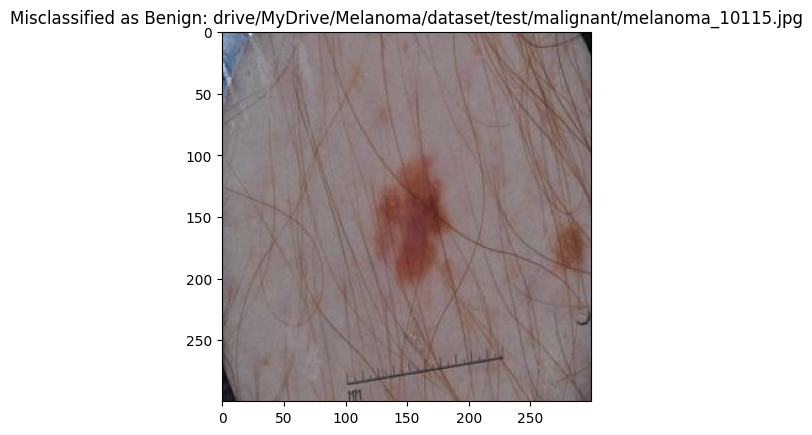

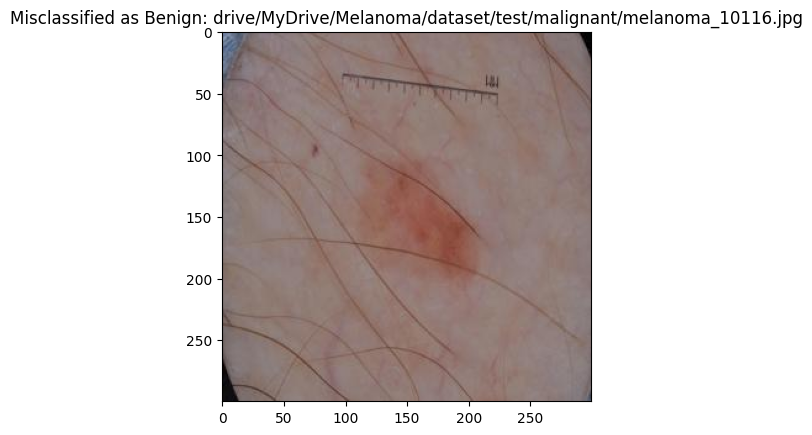

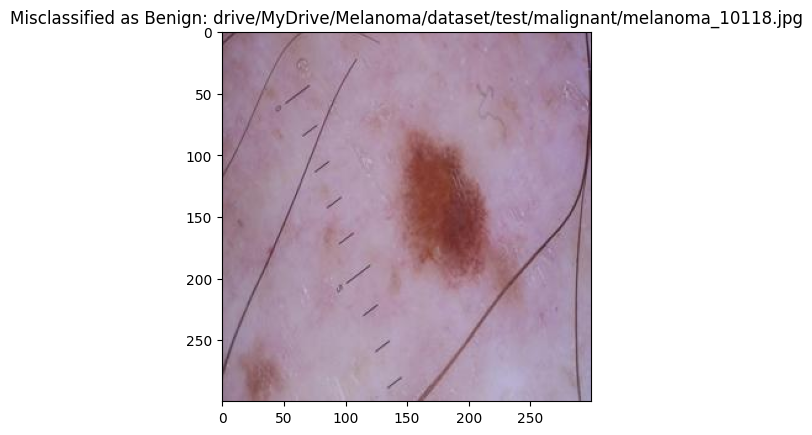

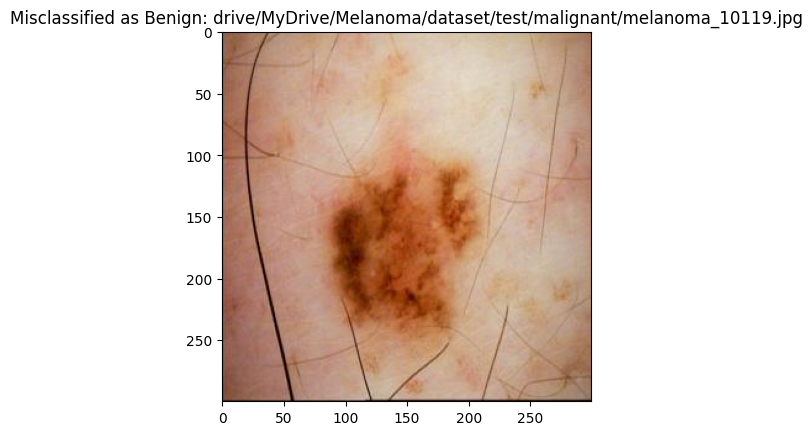

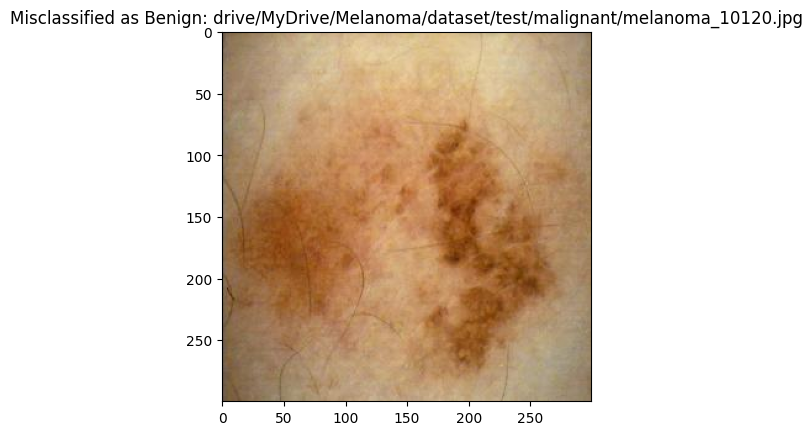

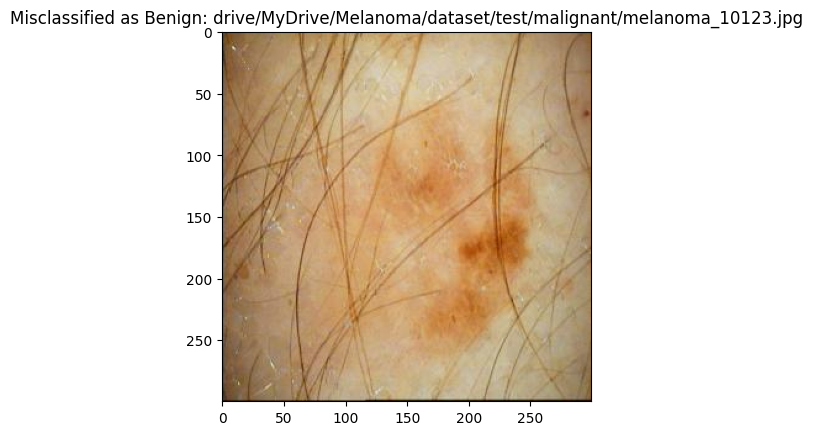

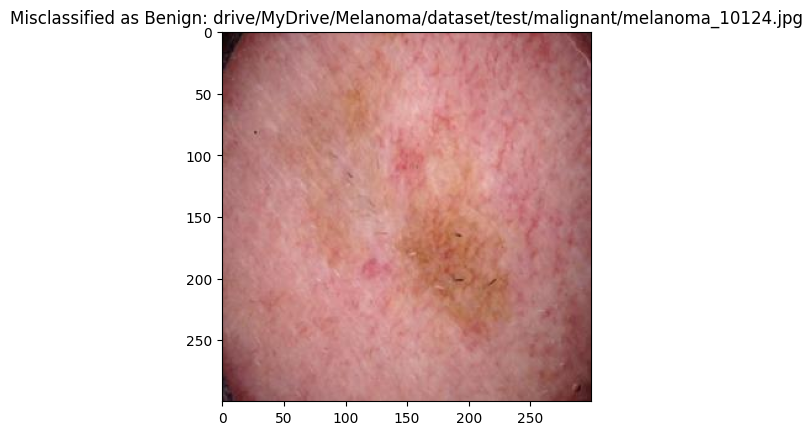

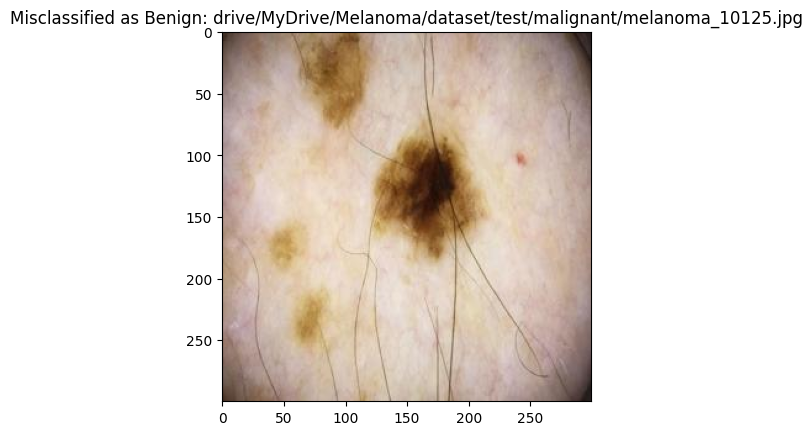

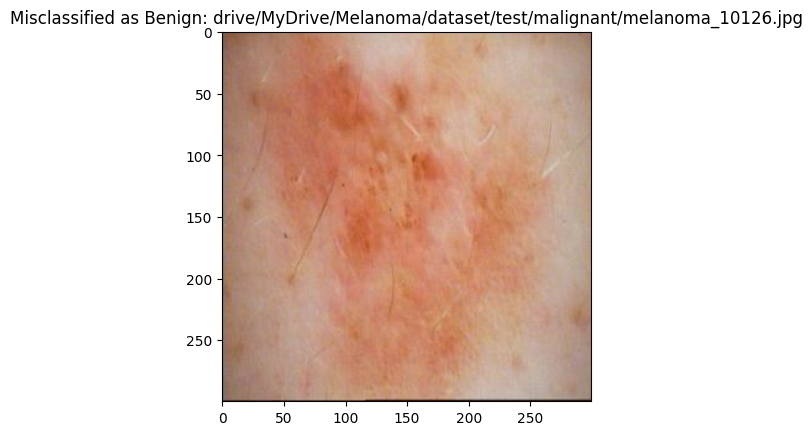

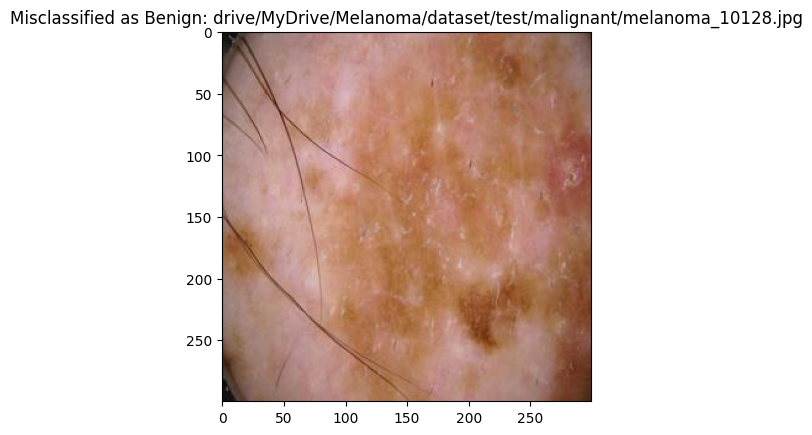

In [ ]:
# Initialize lists to store filenames/indices for misclassified images
misclassified_images = []

#   testLoader has the filenames or some identifier
# Modify  loop to keep track of indices or filenames
with torch.no_grad():
    for i, (inputs, labels) in enumerate(testLoader):
        # Move data to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Perform segmentation and blending
        segmented_image = segmentation_model(inputs)
        inputs = blend_inputs = add_outline_to_image(inputs,
                                            segmented_image)

        # Forward pass
        outputs = model(inputs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs, 1)

        # Store labels, predictions, and probabilities
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(predicted.cpu().numpy())
        all_probs.extend(probs.cpu().numpy()[:, 1])  # Assuming binary classification (for ROC AUC)

        # Check for misclassified melanoma images (label=1 but predicted=0)
        for j in range(len(labels)):
            if labels[j].item() == 1 and predicted[j].item() == 0:
                # Store index or filename of misclassified image
                misclassified_images.append(testLoader.dataset.samples[i * testLoader.batch_size + j][0])

# Print out misclassified melanoma images
print(f'Total misclassified melanoma images: {len(misclassified_images)}')
for img_path in misclassified_images:
    print(f'Misclassified image path: {img_path}')

# display some of the misclassified images
import matplotlib.image as mpimg

for img_path in misclassified_images[:15]:  # Display first 5 misclassified images
    img = mpimg.imread(img_path)
    # img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(f'Misclassified as Benign: {img_path}')
    plt.show()


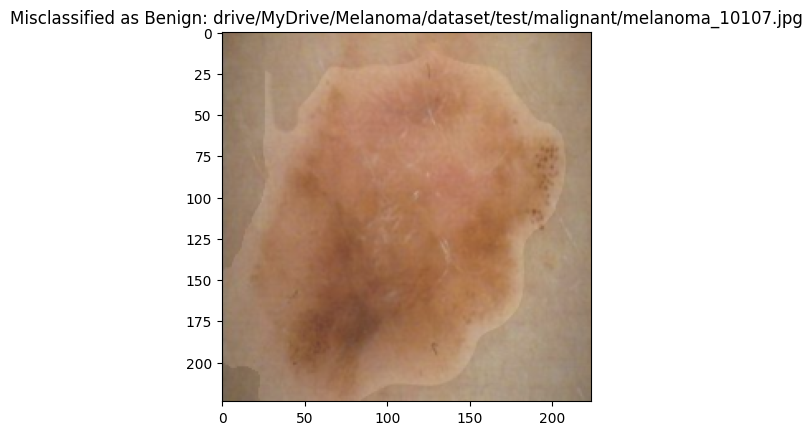

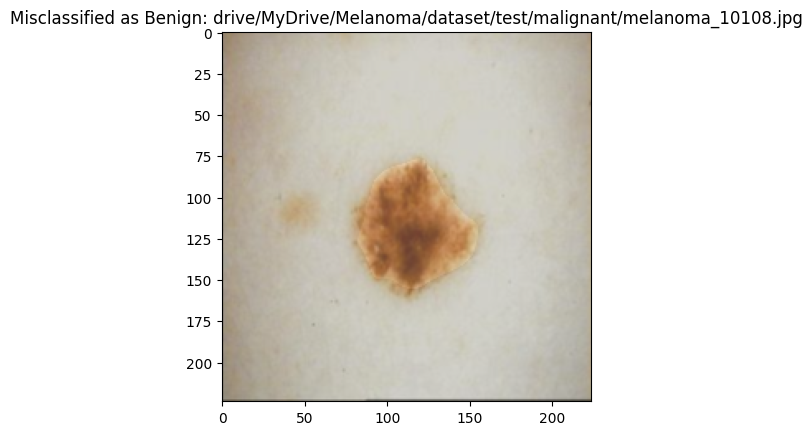

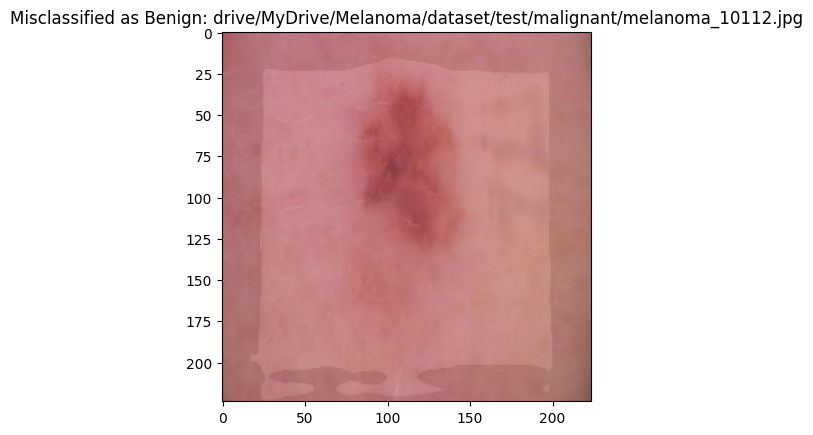

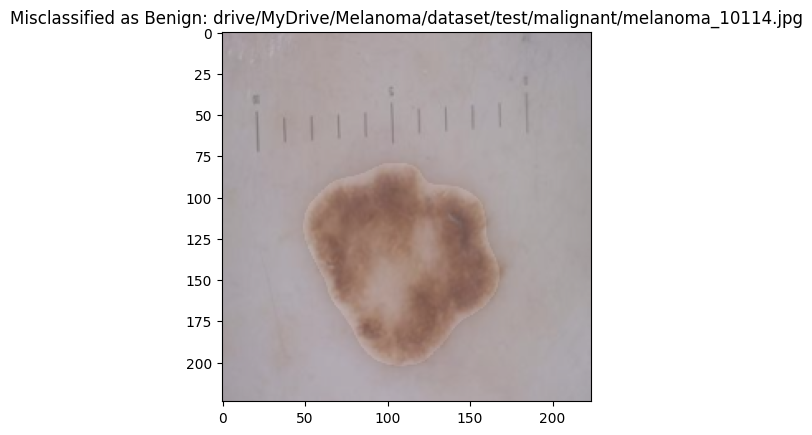

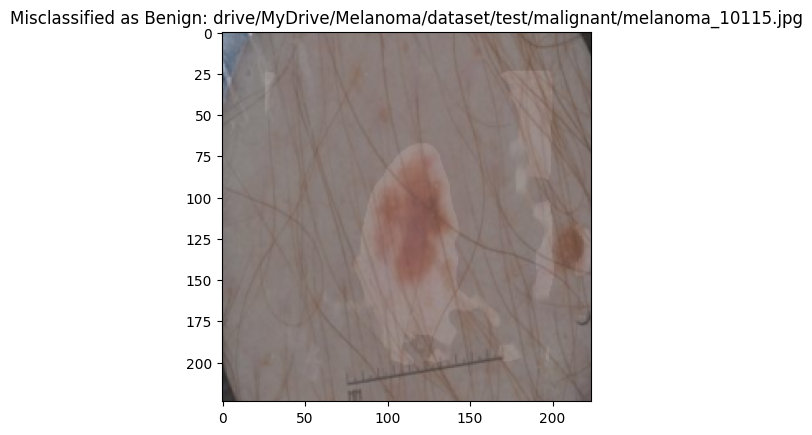

In [ ]:
# Initialize lists to store filenames/indices and blended images for misclassified images
misclassified_images = []
misclassified_blended_images = []

with torch.no_grad():
    for i, (inputs, labels) in enumerate(testLoader):
        # Move data to the correct device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Perform segmentation and blending
        segmented_image = segmentation_model(inputs)
        blended_inputs = add_outline_to_image(inputs,
                                            segmented_image)

        # Forward pass
        outputs = model(blended_inputs)
        probs = torch.softmax(outputs, dim=1)  # Get probabilities
        _, predicted = torch.max(outputs, 1)

        # Check for misclassified melanoma images (label=1 but predicted=0)
        for j in range(len(labels)):
            if labels[j].item() == 1 and predicted[j].item() == 0:
                # Store index or filename of misclassified image and the blended version
                misclassified_images.append(testLoader.dataset.samples[i * testLoader.batch_size + j][0])
                misclassified_blended_images.append(blended_inputs[j].cpu())

# Display misclassified melanoma images with their blended segmentations
import torchvision.transforms as transforms

# Unnormalize the image for display (if normalized the inputs during preprocessing)
unnormalize = transforms.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225],
                                   std=[1/0.229, 1/0.224, 1/0.225])

for img_path, blended_img in zip(misclassified_images[:5], misclassified_blended_images[:5]):  # Display first 5 misclassified images
    # Unnormalize the blended image for display
    blended_img = unnormalize(blended_img)
    blended_img = blended_img.permute(1, 2, 0).numpy()  # Convert to (H, W, C) for matplotlib

    plt.imshow(blended_img)
    plt.title(f'Misclassified as Benign: {img_path}')
    plt.show()
